In [1]:
from collections import defaultdict

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

from scipy import spatial
import timeit
from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds
from scipy import sparse

In [2]:
X_train = pd.read_csv("../feature/X_train.csv")
y_train = pd.read_csv("../feature/y_train.csv")

X_val   = pd.read_csv("../feature/X_val.csv")
y_val   = pd.read_csv("../feature/y_val.csv")

print(X_train.shape, '\n')
# print(X_train.columns)

print(X_val.shape, '\n')
# print(X_val.columns)


(150232, 59) 

(50077, 59) 



In [3]:
# here we decide to merge them intoa large "training set"
X_train = pd.concat([X_train, X_val], ignore_index=True)
y_train = pd.concat([y_train, y_val], ignore_index=True)

print(X_train.shape, '\n')
# print(X_train.columns)

(200309, 59) 



In [4]:
pd.options.display.max_columns = X_train.shape[1]
X_train.describe()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool,fans,funny,review_count_x,useful,date_since,attributes_AcceptsInsurance,attributes_AgesAllowed,attributes_Alcohol,attributes_BYOB,attributes_BikeParking,attributes_BusinessAcceptsBitcoin,attributes_BusinessAcceptsCreditCards,attributes_ByAppointmentOnly,attributes_Caters,attributes_CoatCheck,attributes_Corkage,attributes_DogsAllowed,attributes_DriveThru,attributes_GoodForDancing,attributes_GoodForKids,attributes_HappyHour,attributes_HasTV,attributes_NoiseLevel,attributes_Open24Hours,attributes_OutdoorSeating,attributes_RestaurantsAttire,attributes_RestaurantsCounterService,attributes_RestaurantsDelivery,attributes_RestaurantsGoodForGroups,attributes_RestaurantsPriceRange2,attributes_RestaurantsReservations,attributes_RestaurantsTableService,attributes_RestaurantsTakeOut,attributes_Smoking,attributes_WheelchairAccessible,attributes_WiFi,is_open,review_count_y,stars,state,cate_Restaurants,cate_Entertainment,cate_Travel,city
count,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.0,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.000000,200309.0,200309.000000,200309.000000,200309.000000,200309.000000
mean,3.769307,151.180915,7.987080,151.180915,103.724581,4.880869,11.634595,64.495155,66.751199,157.246574,10.326146,58.673509,824.052309,43.457613,581.545872,382.632303,920.117294,2011.180017,-0.991783,0.008327,0.901637,3.0,0.609828,-0.844855,0.878523,-0.902835,0.220105,-0.773150,-0.911522,-0.667339,-0.917183,-0.763785,0.480293,-0.621784,0.283013,1.019175,-0.960321,0.259749,0.503697,-0.935984,-0.086631,0.563484,1.724051,0.205258,0.380717,0.565941,2.660724,0.485285,0.860855,0.885971,593.868673,3.794587,17.0,0.788966,0.083152,0.048575,3.758783
std,0.495670,615.716966,89.724416,615.716966,605.453620,49.664578,65.880209,227.969166,503.014284,596.158442,96.996649,239.178322,4293.616933,104.497764,3346.202501,691.778723,4230.574842,2.423148,0.114813,0.090873,0.914367,0.0,0.665397,0.368007,0.452416,0.336267,0.734903,0.474335,0.343980,0.615968,0.307620,0.481061,0.743133,0.754887,0.775122,1.618050,0.206392,0.744012,0.843189,0.323573,0.562744,0.800545,0.967645,0.762858,0.837976,0.771443,0.796591,0.844116,1.015451,0.317847,866.988719,0.556216,0.0,0.408105,0.276202,0.215094,5.122888
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2005.000000,-1.000000,0.000000,0.000000,3.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,100.000000,1.000000,17.0,-1.000000,-1.000000,-1.000000,0.000000
25%,3.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,49.000000,5.000000,2009.000000,-1.000000,0.000000,0.000000,3.0,0.000000,-1.000000,1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0

In [5]:
biz_cols = [
       'business_id', 
       'is_open',
       'stars', ## different?
       'review_count_y', ## different
    
       'city',
       'state',
       
       'cate_Restaurants',
       'cate_Entertainment',
       'cate_Travel',
    
       'attributes_AcceptsInsurance',
       'attributes_AgesAllowed', 
       'attributes_Alcohol',
       'attributes_BYOB',
       'attributes_BikeParking', 
       'attributes_BusinessAcceptsBitcoin',
       'attributes_BusinessAcceptsCreditCards', 
       'attributes_ByAppointmentOnly', 
       'attributes_Caters',
       'attributes_CoatCheck', 
       'attributes_Corkage',
       'attributes_DogsAllowed',
       'attributes_DriveThru', 
       'attributes_GoodForDancing',
       'attributes_GoodForKids', 
       'attributes_HappyHour',
       'attributes_HasTV',  
       'attributes_NoiseLevel',
       'attributes_Open24Hours', 
       'attributes_OutdoorSeating',
       'attributes_RestaurantsAttire', 
       'attributes_RestaurantsCounterService',
       'attributes_RestaurantsDelivery',
       'attributes_RestaurantsGoodForGroups',
       'attributes_RestaurantsPriceRange2',
       'attributes_RestaurantsReservations',
       'attributes_RestaurantsTableService', 
       'attributes_RestaurantsTakeOut',
       'attributes_Smoking', 
       'attributes_WheelchairAccessible',
       'attributes_WiFi'
       ]



In [6]:
# extract business info
business = X_train[biz_cols]

print(business.shape)
# business.head()

# drop duplicates
business = business.drop_duplicates()

print(business.shape)
# business.head()

pd.options.display.max_columns = business.shape[1]
business.describe()

(200309, 40)
(12031, 40)


,is_open,stars,review_count_y,city,state,cate_Restaurants,cate_Entertainment,cate_Travel,attributes_AcceptsInsurance,attributes_AgesAllowed,attributes_Alcohol,attributes_BYOB,attributes_BikeParking,attributes_BusinessAcceptsBitcoin,attributes_BusinessAcceptsCreditCards,attributes_ByAppointmentOnly,attributes_Caters,attributes_CoatCheck,attributes_Corkage,attributes_DogsAllowed,attributes_DriveThru,attributes_GoodForDancing,attributes_GoodForKids,attributes_HappyHour,attributes_HasTV,attributes_NoiseLevel,attributes_Open24Hours,attributes_OutdoorSeating,attributes_RestaurantsAttire,attributes_RestaurantsCounterService,attributes_RestaurantsDelivery,attributes_RestaurantsGoodForGroups,attributes_RestaurantsPriceRange2,attributes_RestaurantsReservations,attributes_RestaurantsTableService,attributes_RestaurantsTakeOut,attributes_Smoking,attributes_WheelchairAccessible,attributes_WiFi
count,12031.000000,12031.000000,12031.000000,12031.000000,12031.0,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.0,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000
mean,0.889203,3.782271,267.265148,5.031918,17.0,0.742249,0.052282,0.033580,-0.980218,0.004987,1.040063,3.0,0.609343,-0.846563,0.879561,-0.859696,0.186019,-0.803757,-0.957360,-0.706758,-0.916549,-0.793367,0.405369,-0.661375,0.207630,1.205802,-0.982046,0.186352,0.578589,-0.967334,-0.113706,0.466379,1.556728,0.121021,0.281190,0.507522,2.696451,0.363976,0.996509
std,0.313894,0.628494,324.927672,5.766024,0.0,0.437604,0.222977,0.180614,0.176154,0.070446,0.924709,0.0,0.692311,0.369533,0.450038,0.424633,0.782375,0.442699,0.242103,0.582756,0.313749,0.451681,0.813539,0.725640,0.810639,1.709599,0.140691,0.775680,0.888901,0.235672,0.611911,0.860037,1.041493,0.784397,0.867906,0.825562,0.773922,0.900408,1.121314
min,0.000000,1.000000,100.000000,0.000000,17.0,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,3.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000
25%,1.000000,3.500000,127.000000,0.000000,17.0,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,3.0,0.000000,-1.000000,1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.000000,3.000000,-1.000000,0.000000
50%,1.000000,4.000000,174.000000,3.000000,17.0,1.000000,0.000000,0.000000,-1.000000,0.000000,1.000000,3.0,1.000000,-1.000000,1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,1.000000,2.000000,0.000000,1.000000,1.000000,3.000000,1.000000,1.000000
75%,1.000000,4.000000,282.000000,8.000000,17.0,1.000000,0.000000,0.000000,-1.000000,0.000000,2.000000,3.0,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,1.000000,3.000000,-1.000000,1.000000,2.000000,-1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000
max,1.000000,5.000000,7968.000000,17.000000,17.0,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,3.000000,1.000000,3.000000


In [7]:
print(business.index)
# reset the indices of business
# for convenience of indexing in biz_sim_mat
business = business.reset_index(drop=True)
print(business.index)

Int64Index([     0,     11,     18,     78,    182,    187,    216,    233,
               249,    300,
            ...
            200164, 200178, 200180, 200198, 200209, 200230, 200242, 200276,
            200279, 200308],
           dtype='int64', length=12031)
RangeIndex(start=0, stop=12031, step=1)


In [8]:
# for fast accessing index (number) given id (string)... in user
# business.index[business["business_id"] == business_id] is slow
n_biz = business.shape[0]
biz_id_index_dict = {business.loc[index, 'business_id']: index for index in range(n_biz)}

len(biz_id_index_dict) == business.shape[0]

True

In [9]:
biz_attrs = [
       'attributes_AcceptsInsurance',
       'attributes_AgesAllowed', 
       'attributes_Alcohol',
       'attributes_BYOB',
       'attributes_BikeParking', 
       'attributes_BusinessAcceptsBitcoin',
       'attributes_BusinessAcceptsCreditCards', 
       'attributes_ByAppointmentOnly', 
       'attributes_Caters',
       'attributes_CoatCheck', 
       'attributes_Corkage',
       'attributes_DogsAllowed',
       'attributes_DriveThru', 
       'attributes_GoodForDancing',
       'attributes_GoodForKids', 
       'attributes_HappyHour',
       'attributes_HasTV',  
       'attributes_NoiseLevel',
       'attributes_Open24Hours', 
       'attributes_OutdoorSeating',
       'attributes_RestaurantsAttire', 
       'attributes_RestaurantsCounterService',
       'attributes_RestaurantsDelivery',
       'attributes_RestaurantsGoodForGroups',
       'attributes_RestaurantsPriceRange2',
       'attributes_RestaurantsReservations',
       'attributes_RestaurantsTableService', 
       'attributes_RestaurantsTakeOut',
       'attributes_Smoking', 
       'attributes_WheelchairAccessible',
       'attributes_WiFi'
       ];
      
n_biz_attrs = len(biz_attrs)
print(n_biz_attrs)

31


In [10]:
# (minmax) normalize values of attributes 
business[biz_attrs] = business[biz_attrs].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) if np.max(x) != np.min(x) else 0.0)

print(business.shape)
# business.head()

pd.options.display.max_columns = business.shape[1]
business.describe()

(12031, 40)


,is_open,stars,review_count_y,city,state,cate_Restaurants,cate_Entertainment,cate_Travel,attributes_AcceptsInsurance,attributes_AgesAllowed,attributes_Alcohol,attributes_BYOB,attributes_BikeParking,attributes_BusinessAcceptsBitcoin,attributes_BusinessAcceptsCreditCards,attributes_ByAppointmentOnly,attributes_Caters,attributes_CoatCheck,attributes_Corkage,attributes_DogsAllowed,attributes_DriveThru,attributes_GoodForDancing,attributes_GoodForKids,attributes_HappyHour,attributes_HasTV,attributes_NoiseLevel,attributes_Open24Hours,attributes_OutdoorSeating,attributes_RestaurantsAttire,attributes_RestaurantsCounterService,attributes_RestaurantsDelivery,attributes_RestaurantsGoodForGroups,attributes_RestaurantsPriceRange2,attributes_RestaurantsReservations,attributes_RestaurantsTableService,attributes_RestaurantsTakeOut,attributes_Smoking,attributes_WheelchairAccessible,attributes_WiFi
count,12031.000000,12031.000000,12031.000000,12031.000000,12031.0,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.0,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.00000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000,12031.000000
mean,0.889203,3.782271,267.265148,5.031918,17.0,0.742249,0.052282,0.033580,0.009891,0.004987,0.520032,0.0,0.804671,0.076718,0.939781,0.070152,0.593010,0.098122,0.021320,0.146621,0.041726,0.103316,0.702685,0.169313,0.603815,0.30145,0.008977,0.593176,0.289294,0.016333,0.443147,0.733189,0.511346,0.560510,0.640595,0.753761,0.898817,0.681988,0.332170
std,0.313894,0.628494,324.927672,5.766024,0.0,0.437604,0.222977,0.180614,0.088077,0.070446,0.462354,0.0,0.346155,0.184767,0.225019,0.212316,0.391187,0.221350,0.121052,0.291378,0.156875,0.225841,0.406770,0.362820,0.405319,0.42740,0.070346,0.387840,0.444451,0.117836,0.305955,0.430018,0.208299,0.392198,0.433953,0.412781,0.257974,0.450204,0.373771
min,0.000000,1.000000,100.000000,0.000000,17.0,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.500000,127.000000,0.000000,17.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.500000,0.000000,1.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.00000,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.400000,0.000000,0.000000,0.500000,1.000000,0.000000,0.000000
50%,1.000000,4.000000,174.000000,3.000000,17.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,1.000000,0.000000,1.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000,0.00000,0.000000,0.500000,0.000000,0.000000,0.500000,1.000000,0.600000,0.500000,1.000000,1.000000,1.000000,1.000000,0.333333
75%,1.000000,4.000000,282.000000,8.000000,17.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.75000,0.000000,1.000000,1.000000,0.000000,0.500000,1.000000,0.600000,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333
max,1.000000,5.000000,7968.000000,17.000000,17.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
biz_attr_val = business[biz_attrs].values
biz_attr_val.shape

(12031, 31)

In [12]:
# alternative way: 
# just calculate similarity of 2 businesses when needed
# instead of computing & then stroing similarities of all possible pairs in a matrix
def calculate_similarity(biz_1_index, biz_2_index):
    # thanks to statement "business = business.reset_index(drop=True)" (???)
    # usually default (consecutive) indices works
    l_1, l_2 = biz_attr_val[biz_1_index], biz_attr_val[biz_2_index]
    
    # any other similarity measure?
    # how to reflect the influence of review numbers for a business
    sim = 1 - spatial.distance.cosine(l_1, l_2)
    return sim

In [13]:
user_cols = [
    'user_id',
    'average_stars', 
    'compliment_cool', 
    'compliment_cute',
    'compliment_funny', 
    'compliment_hot', 
    'compliment_list',
    'compliment_more', 
    'compliment_note', 
    'compliment_photos',
    'compliment_plain', 
    'compliment_profile', 
    'compliment_writer', 
    'cool',
    'fans', 
    'funny', 
    'review_count_x', ##different
    'useful',
    'date_since'
]


In [14]:
user = X_train[user_cols]

print(user.shape)
# user.head()

# drop duplicates
user = user.drop_duplicates()

print(user.shape)
# user.head()

pd.options.display.max_columns = user.shape[1]
user.describe()

(200309, 19)
(25379, 19)


,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool,fans,funny,review_count_x,useful,date_since
count,25379.000000,25379.000000,25379.000000,25379.000000,25379.000000,25379.000000,25379.000000,25379.000000,25379.000000,25379.000000,25379.000000,25379.000000,25379.000000,25379.000000,25379.000000,25379.000000,25379.000000,25379.000000
mean,3.775096,15.678474,0.855707,15.678474,11.503172,0.375192,1.316246,6.667126,6.049844,15.054179,0.969424,5.580677,87.394854,5.182434,65.141377,62.718783,116.835927,2012.566177
std,0.836327,213.701942,19.980114,213.701942,198.775048,9.803164,16.381394,73.807609,140.277629,202.918069,22.188998,71.449123,1245.669527,29.014671,962.360914,184.137198,1332.138821,2.550473
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2005.000000
25%,3.380000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,2011.000000
50%,3.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,2.000000,2013.000000
75%,4.310000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,3.000000,48.000000,12.000000,2015.000000
max,5.000000,12478.000000,2250.000000,12478.000000,19085.000000,1305.000000,1440.000000,4659.000000,10820.000000,13075.000000,2327.000000,4352.000000,67566.000000,1593.000000,65804.000000,11942.000000,68448.000000,2018.000000


In [15]:
print(user.index)
# reset the indices of business
# for convenience of indexing in biz_sim_mat
user = user.reset_index(drop=True)
print(user.index)

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            200295, 200296, 200297, 200298, 200299, 200302, 200303, 200306,
            200307, 200308],
           dtype='int64', length=25379)
RangeIndex(start=0, stop=25379, step=1)


In [16]:
# for fast accessing index (number) given id (string)... in user
# user.index[user["user_id"] == user_id] is slow
n_user = user.shape[0]
user_id_index_dict = {user.loc[index, 'user_id']: index for index in range(n_user)}

len(user_id_index_dict) == user.shape[0]

True

In [17]:
# for fast accessing... in review (X_train)
n_review = X_train.shape[0]
review_uid_rindices_dict = {}
review_uid_bids_dict = {}
# https://stackoverflow.com/questions/483666/python-reverse-invert-a-mapping
for r_index in range(n_review):
    r = X_train.iloc[r_index]
    user_id = r['user_id']
    business_id = r['business_id']
    review_uid_rindices_dict.setdefault(user_id, []).append(r_index)
    review_uid_bids_dict.setdefault(user_id, []).append(business_id)
    
print(len(review_uid_rindices_dict), len(review_uid_bids_dict))


25379 25379


In [18]:
# and more...
n_biz = business.shape[0]
biz_id_star_dict = {business.loc[index, 'business_id']: business.loc[index, 'stars'] for index in range(n_biz)}
print(len(biz_id_star_dict))

n_user = user.shape[0]
user_id_star_dict = {user.loc[index, 'user_id']: user.loc[index, 'average_stars'] for index in range(n_user)}
print(len(user_id_star_dict))

12031
25379


In [19]:
def getClusteringRes(X_df, y_df):
    
    clusters = []
    
    for k in range(6):
        
        cluster = {}
        clusters.append(cluster)
        
        y_temp = y_df[y_df['stars'] == float(k)]
        X_temp = X_df.iloc[y_temp.index.values]
        
        clusters[k]["u"] = X_temp['user_id'].values.tolist()
        clusters[k]["b"] = X_temp['business_id'].values.tolist()
        
    return clusters


In [63]:
def plotClusteringRes(clusters, ub, attr):
    
    if ub is 'u':
        df = user
        dt = user_id_index_dict
    else:
        df = business
        dt = biz_id_index_dict
        
    f = plt.figure(figsize=(15,6), dpi=80)
    
    for k in range(6):
        plt.subplot(2,3,k+1)
        cluster = clusters[k]
            
        ids = cluster[ub]
        ls = [df.iloc[dt[id]][attr] for id in ids]
        
        plt.hist(ls, bins=20)
        
        plt.xlabel(ub + ': ' + attr)
        plt.legend('{}'.format(k))
    
    plt.show()

In [21]:
clusters = getClusteringRes(X_train, y_train)
ls1 = [len(clusters[i]['u']) for i in range(6)]
ls2 = [len(clusters[i]['b']) for i in range(6)]
print(ls1, ls2)

[0, 12972, 17215, 35449, 67773, 66900] [0, 12972, 17215, 35449, 67773, 66900]


1


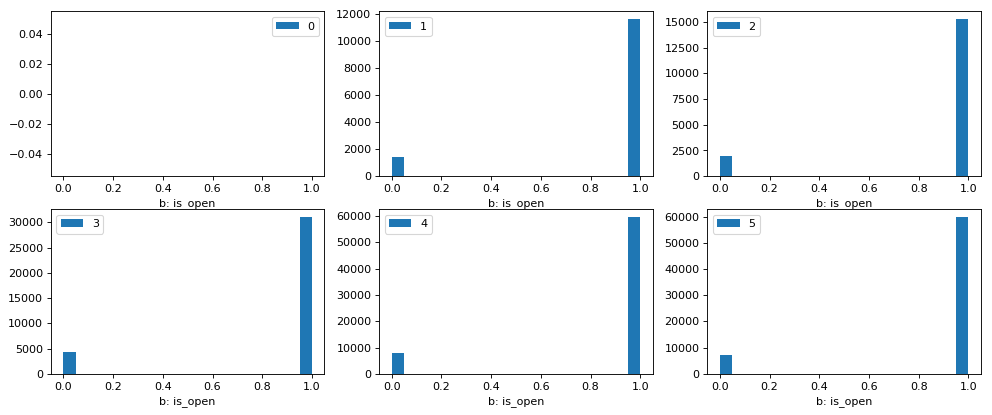

2


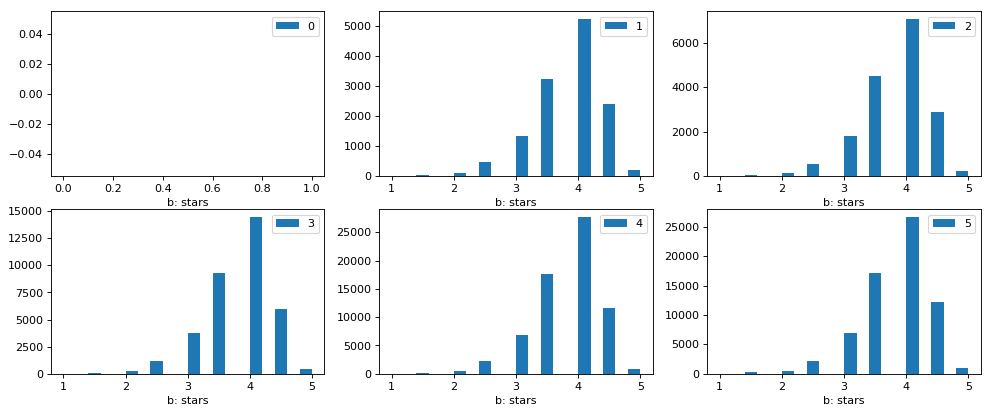

3


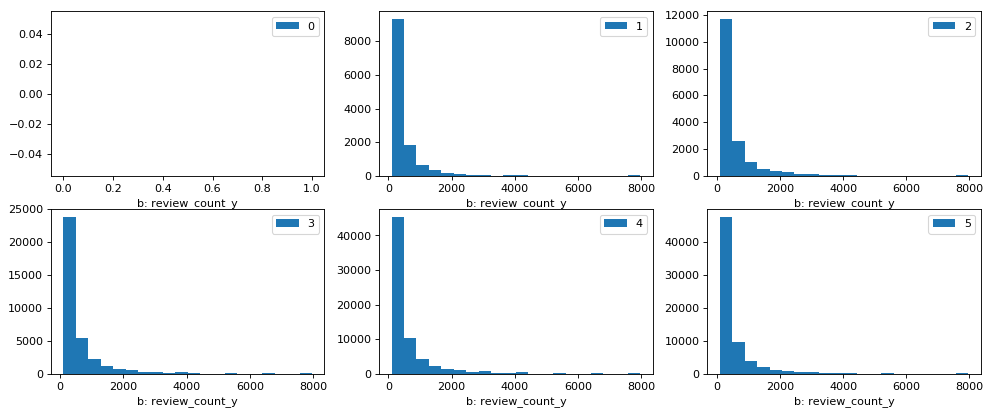

4


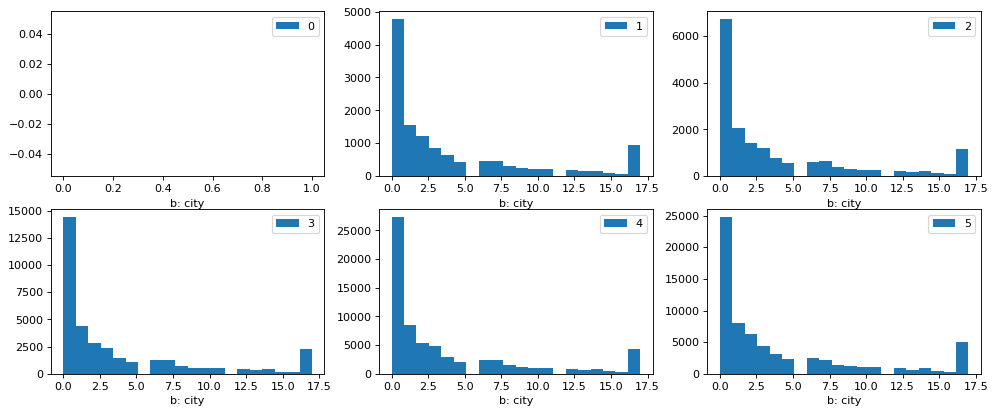

5


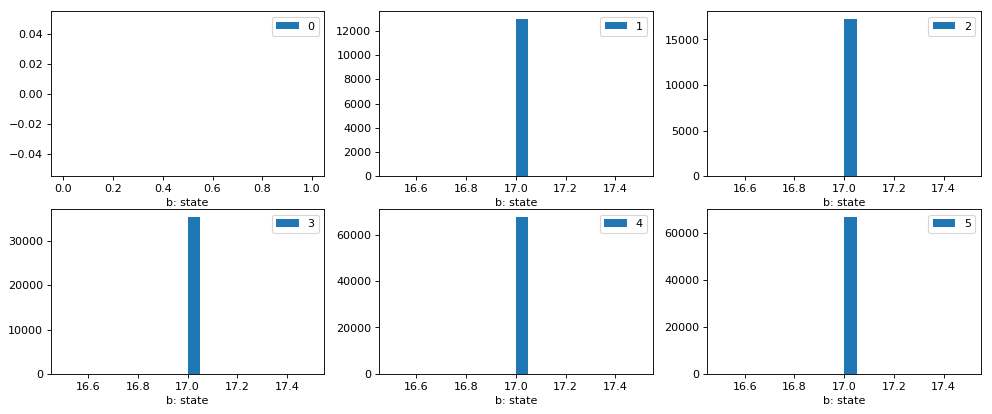

6


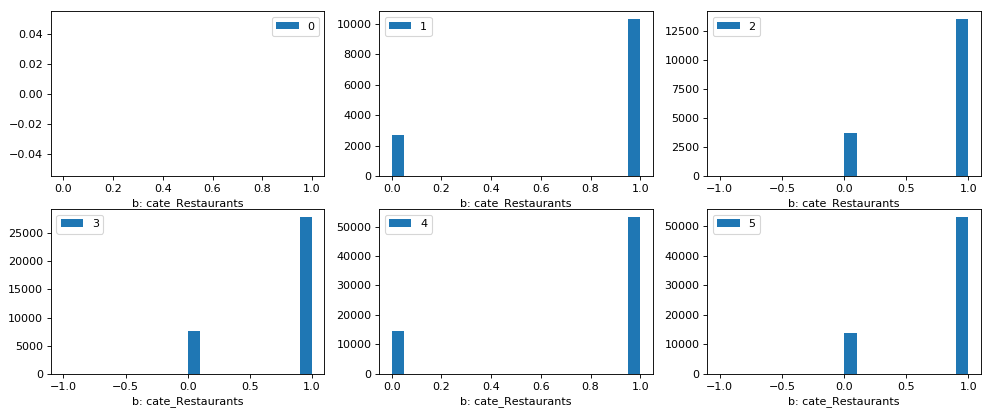

7


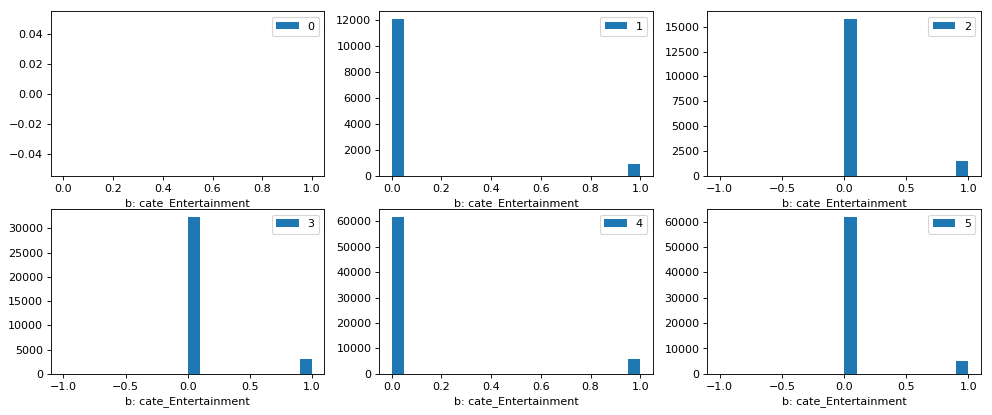

8


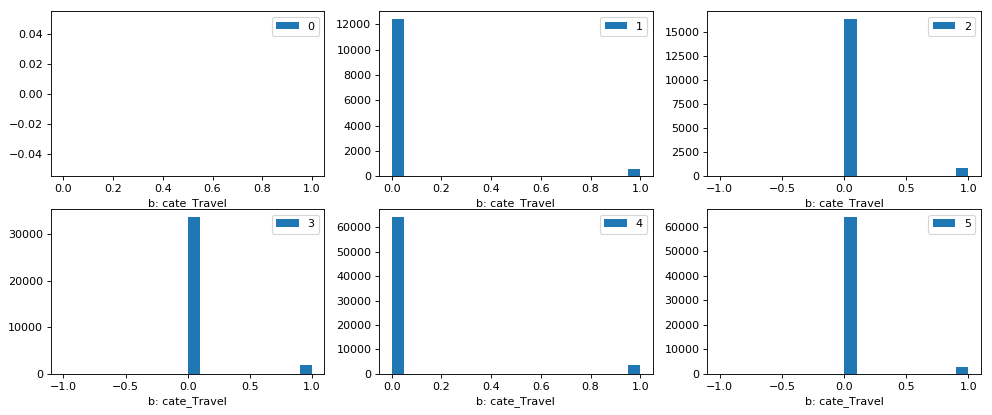

9


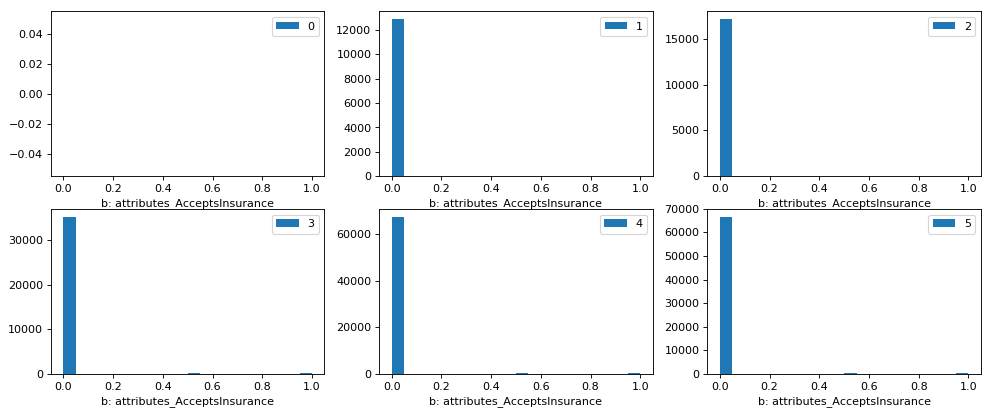

10


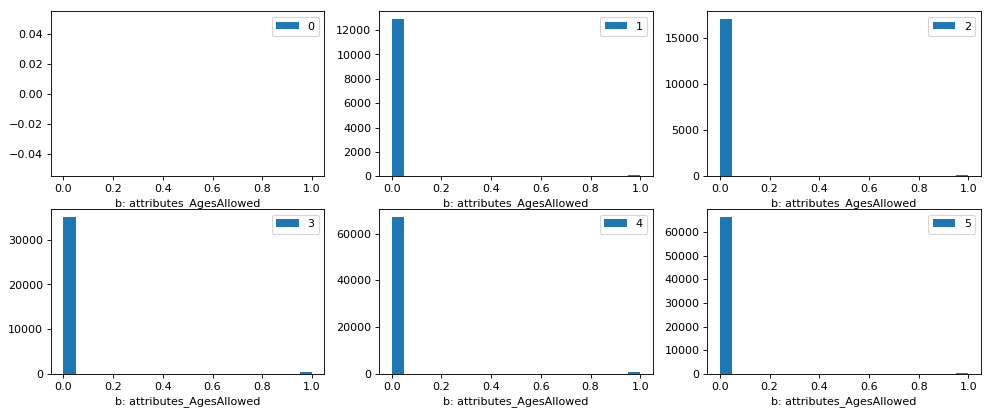

11


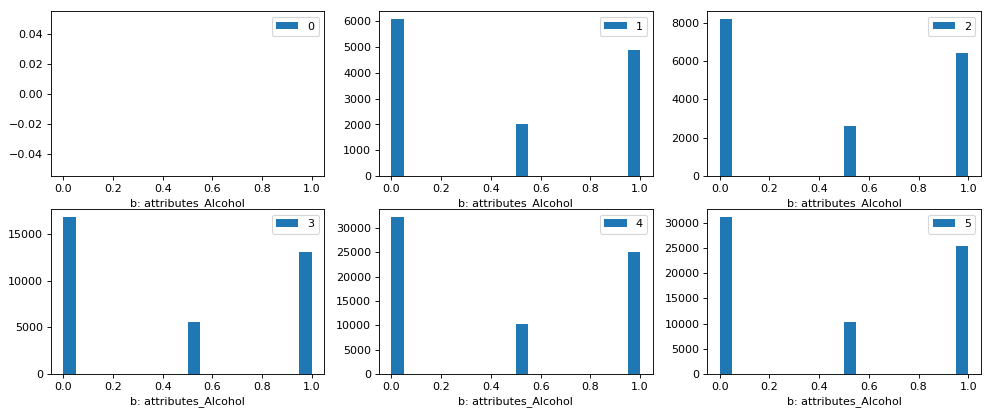

12


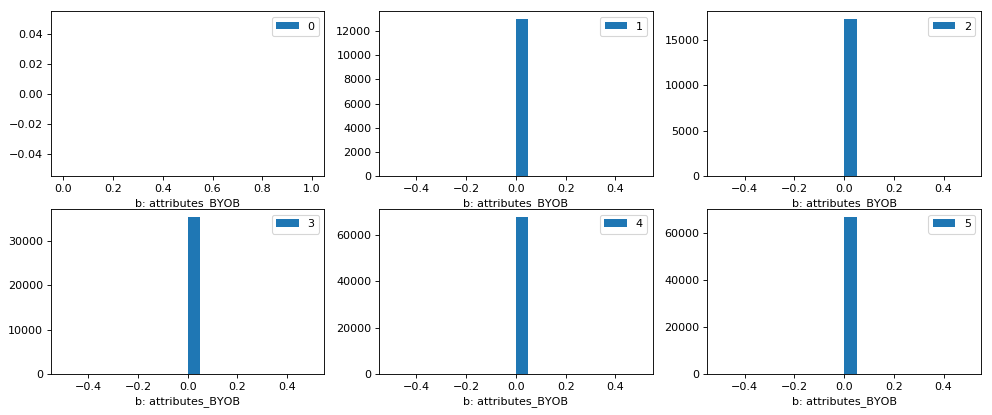

13


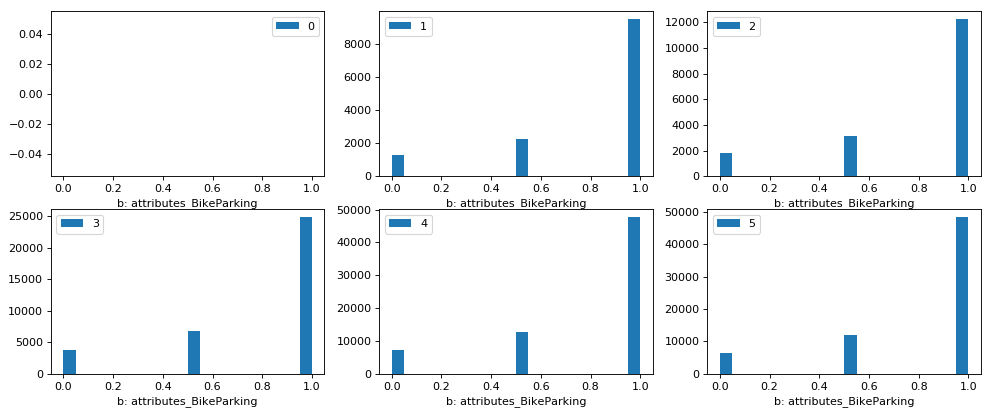

14


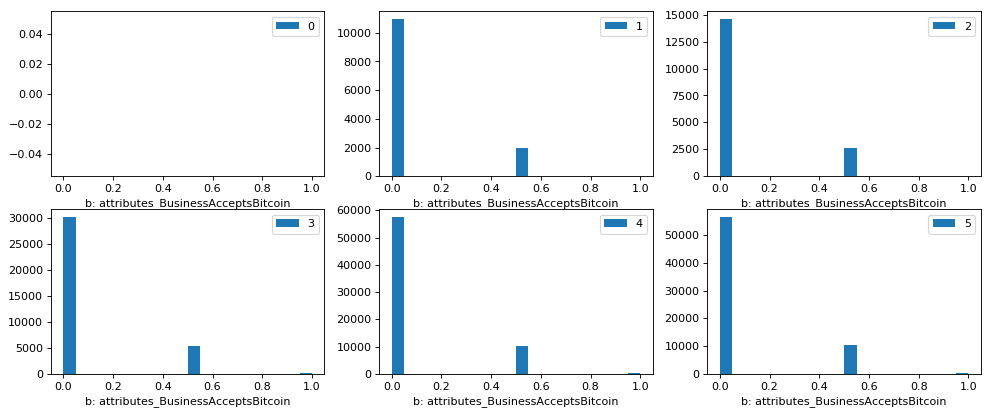

15


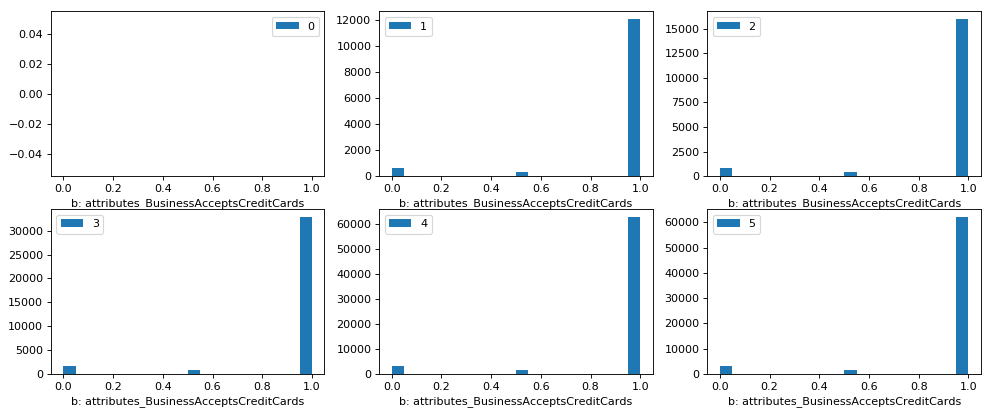

16


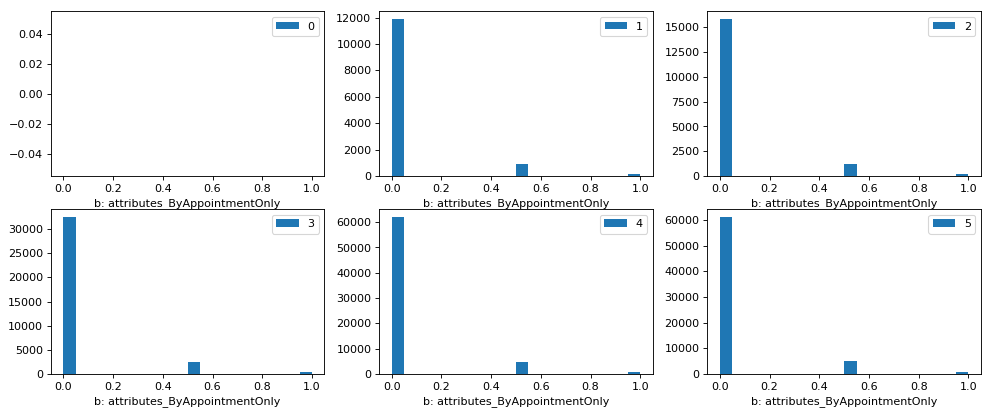

17


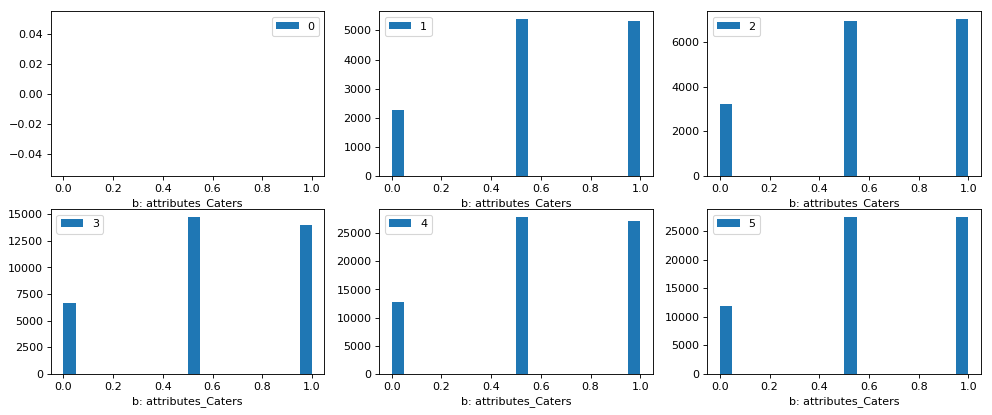

18


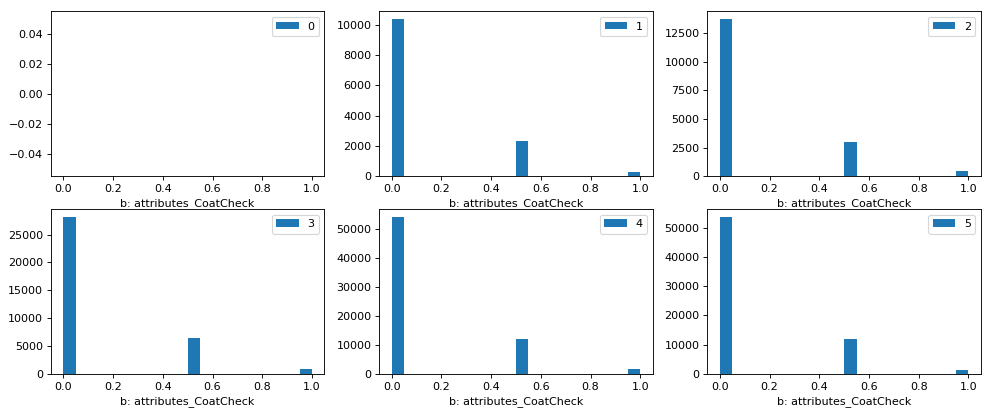

19


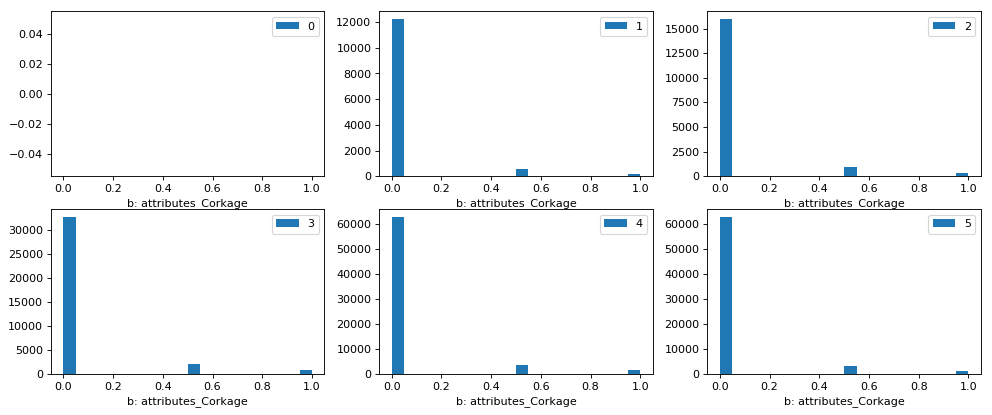

20


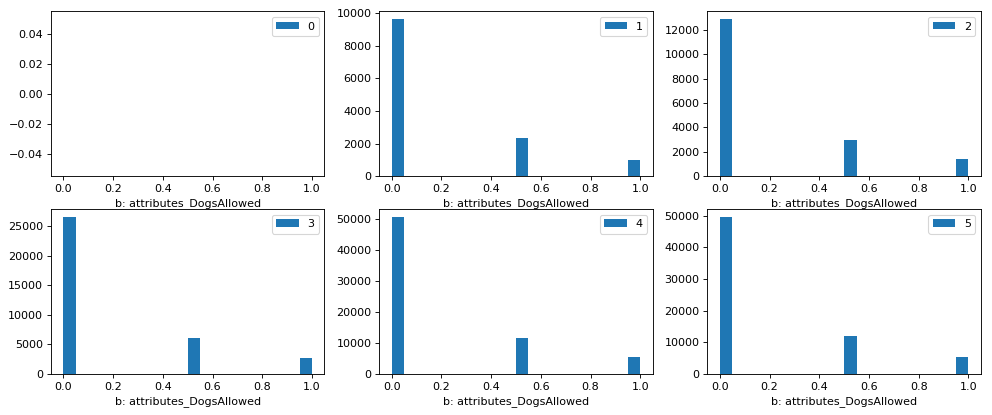

21


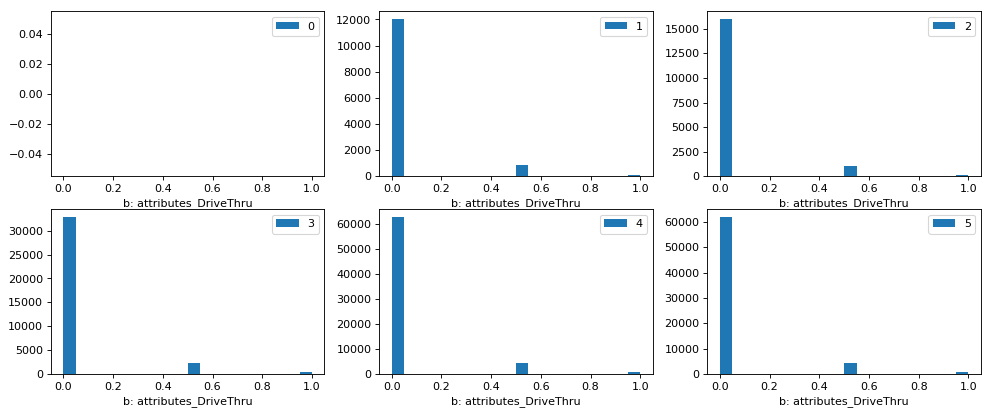

22


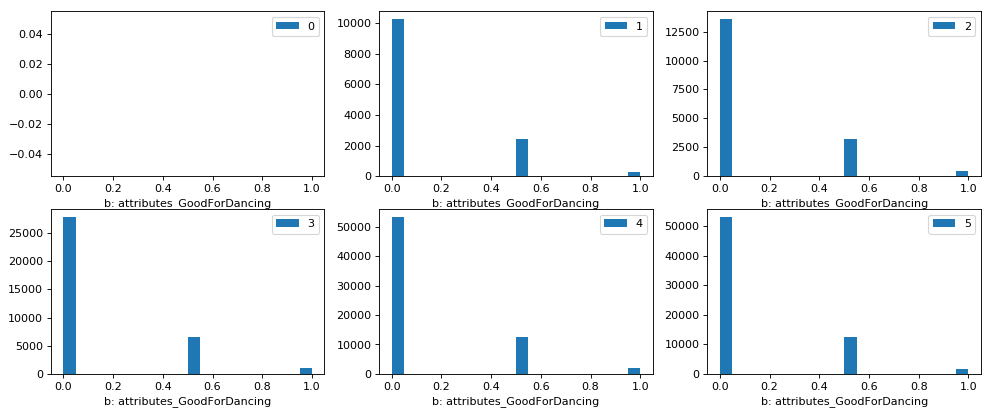

23


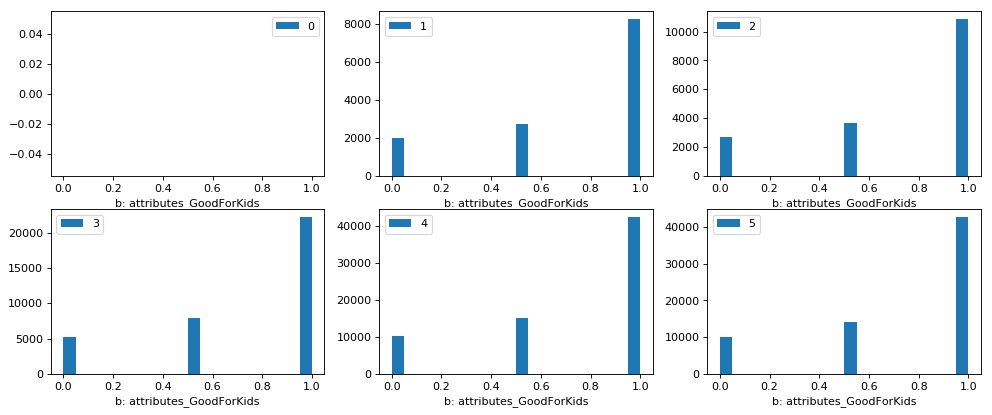

24


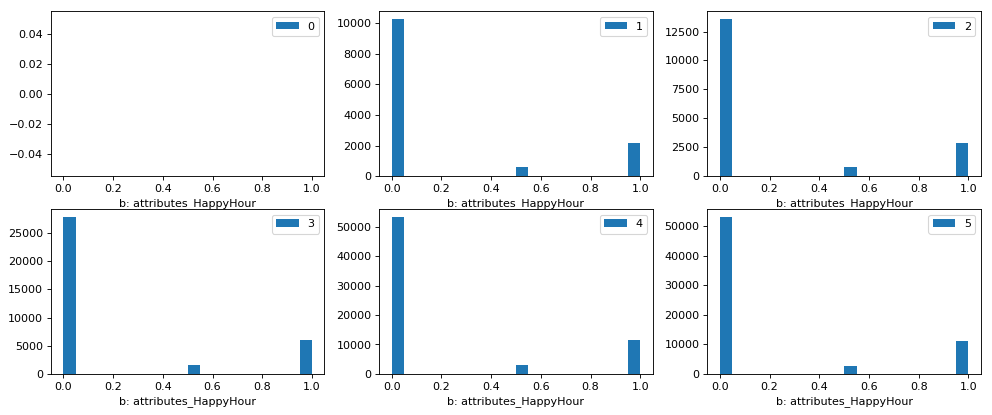

25


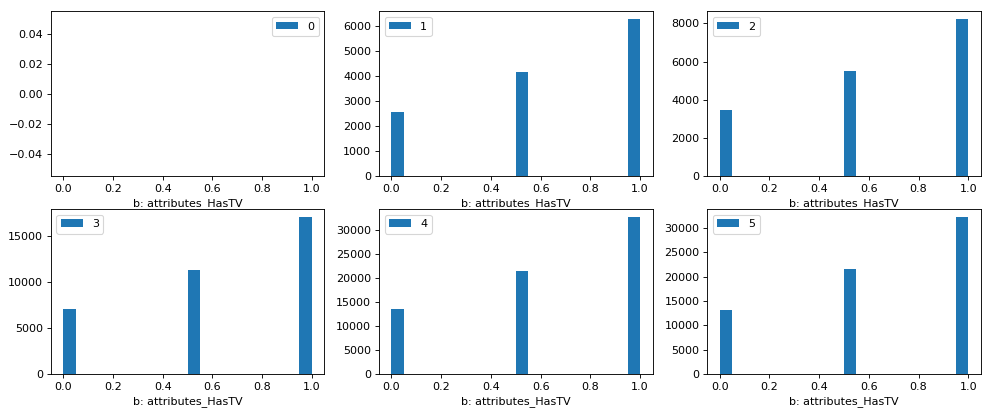

26


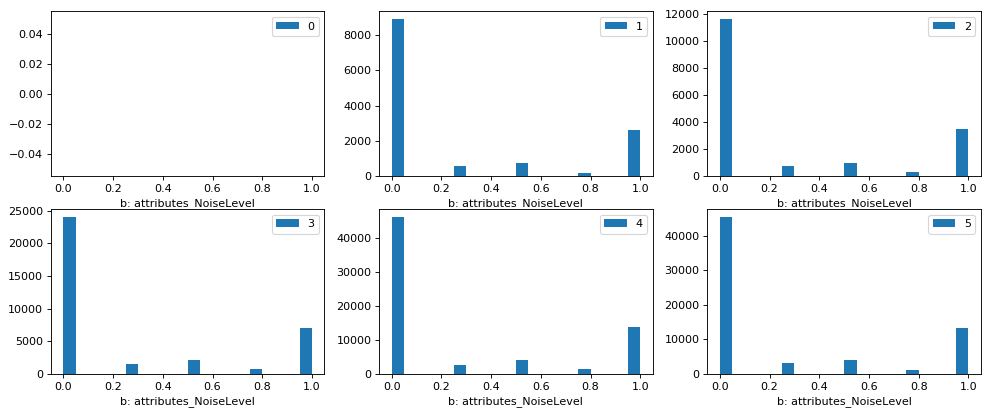

27


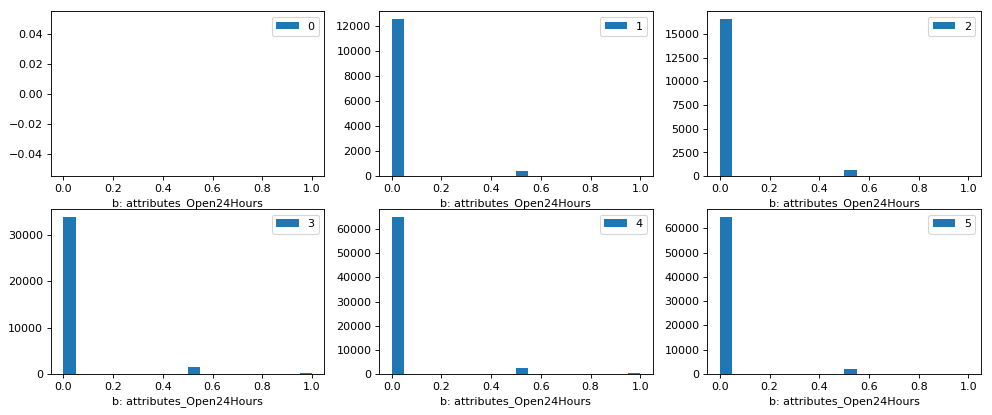

28


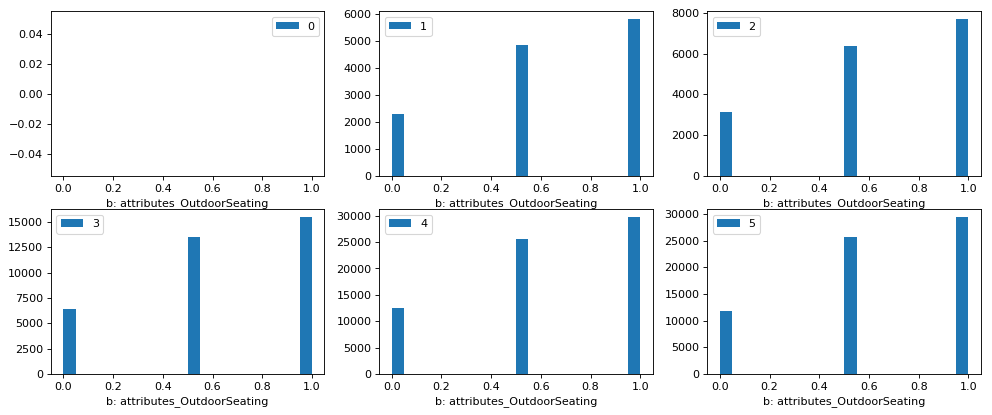

29


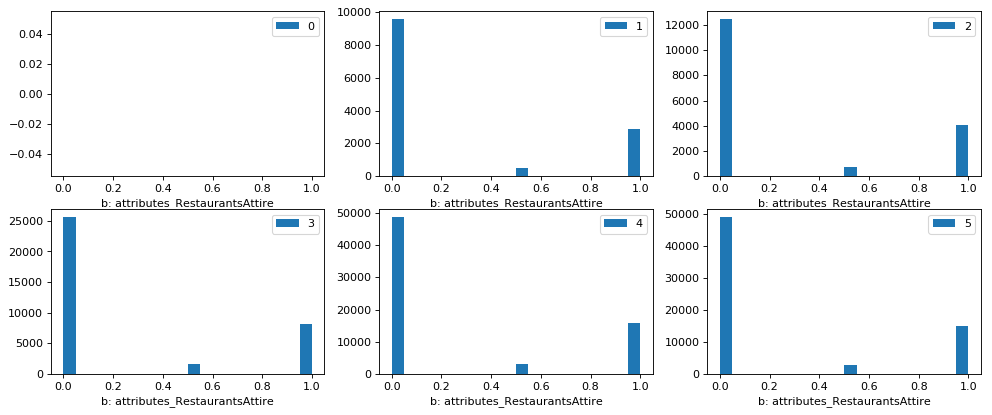

30


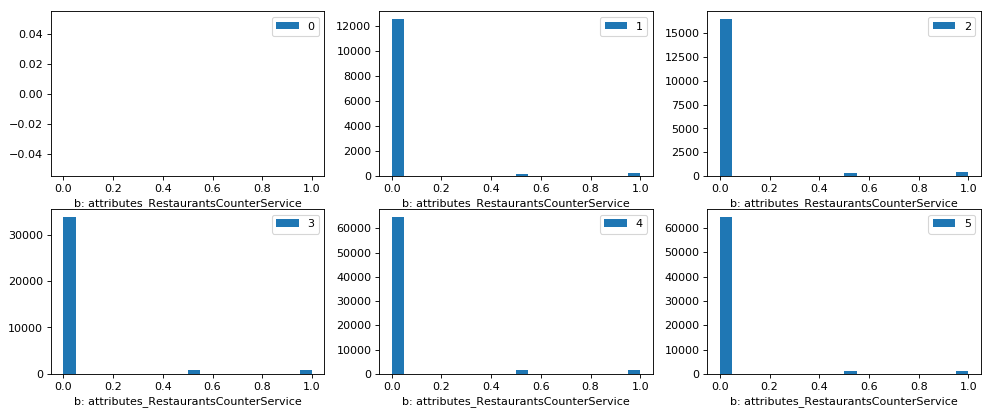

31


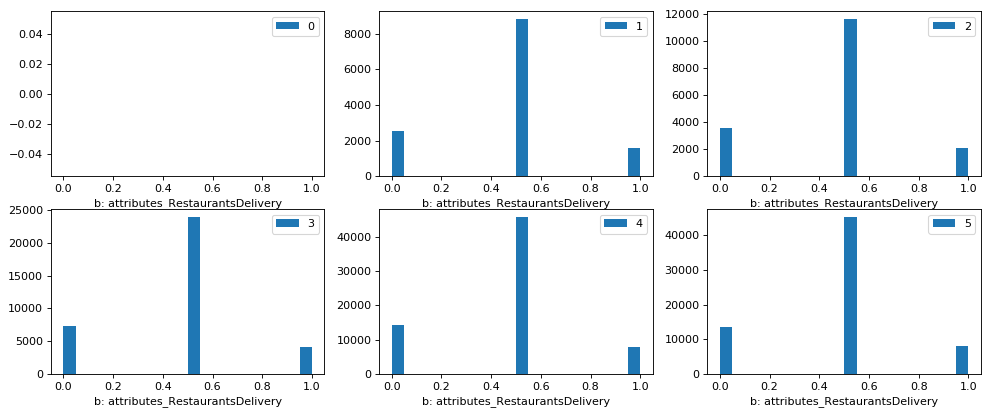

32


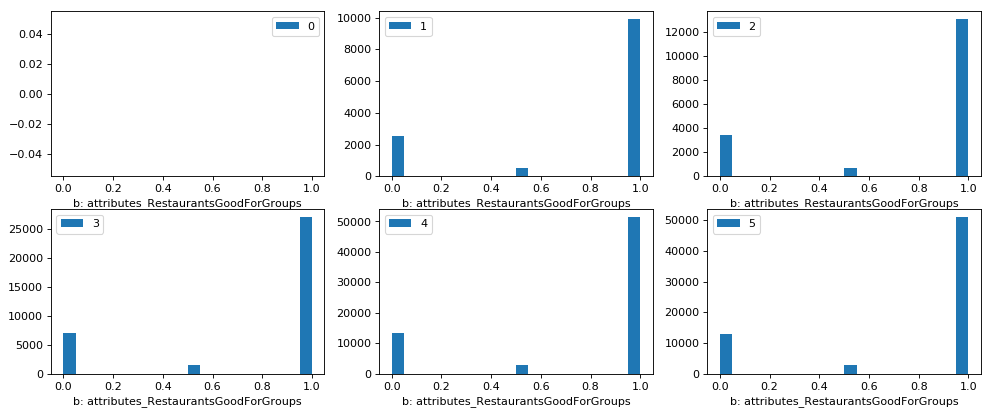

33


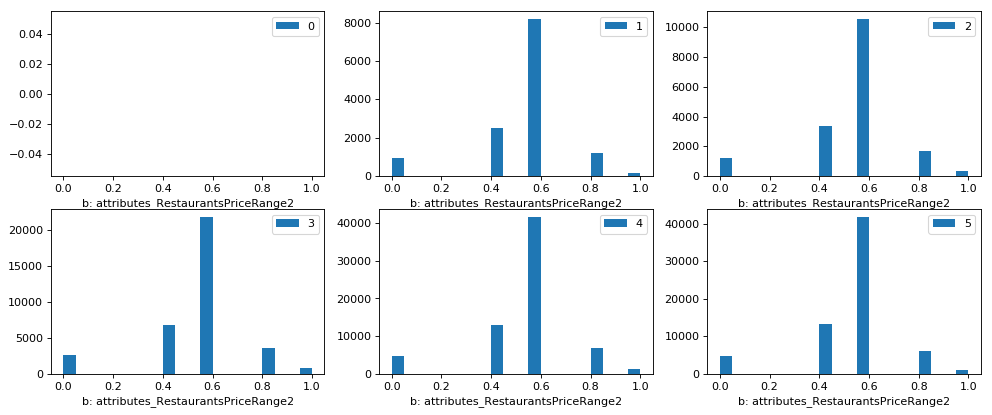

34


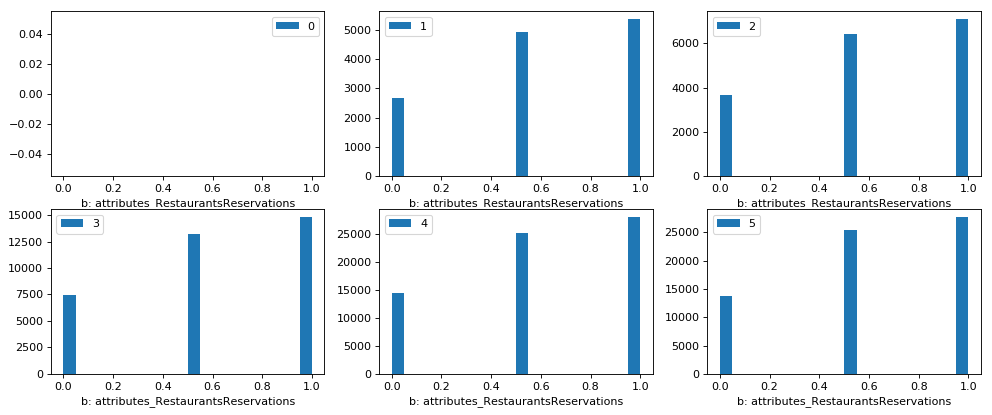

35


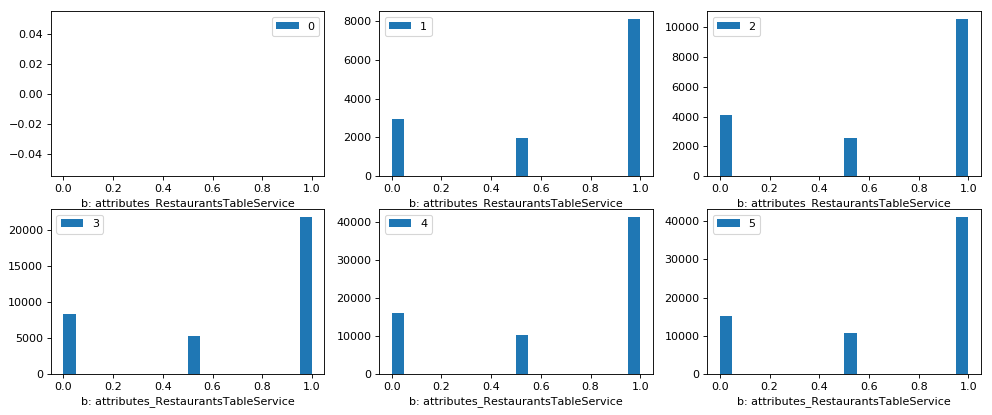

36


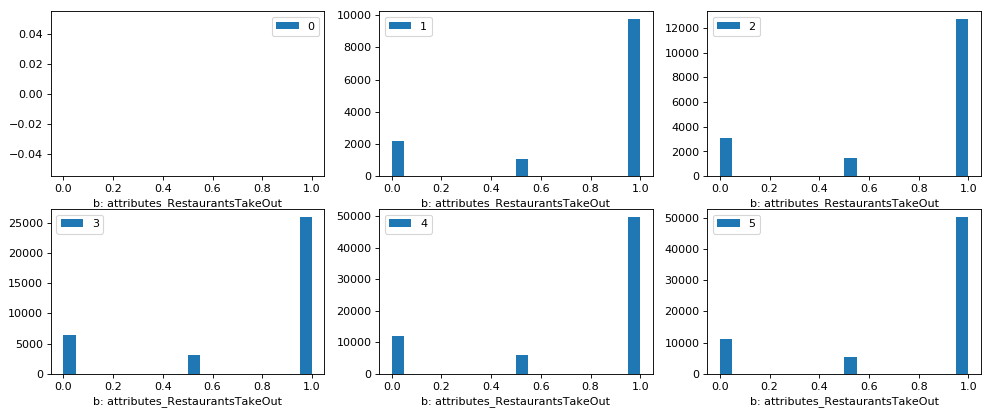

37


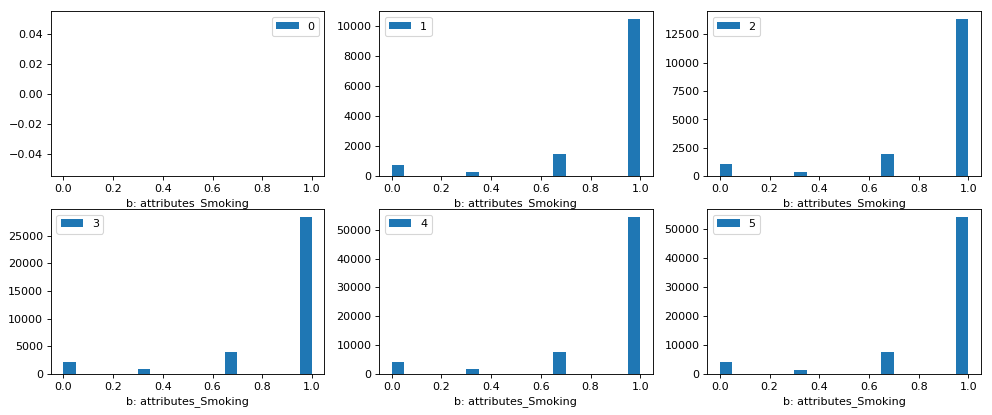

38


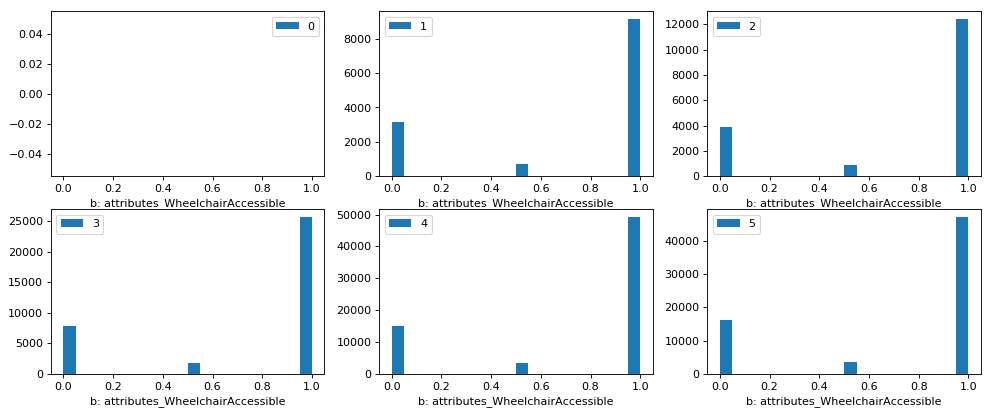

39


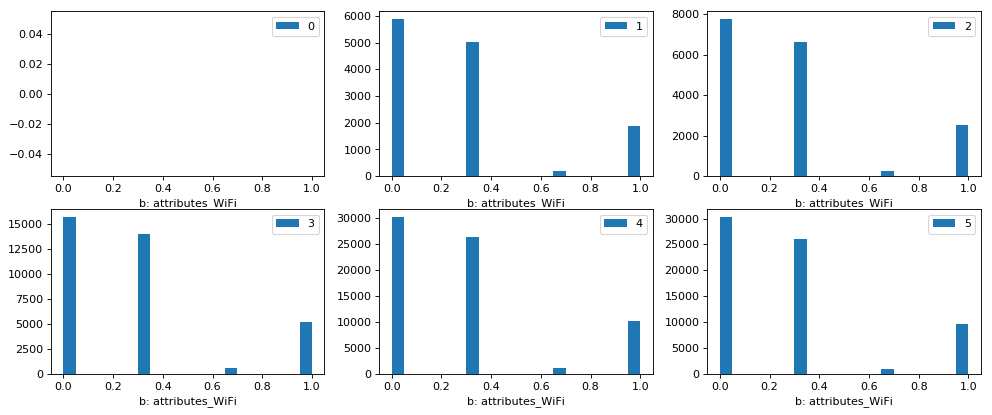

In [64]:
for i in range(1,len(biz_cols)):
    print(i)
    plotClusteringRes(clusters, 'b', biz_cols[i])

1


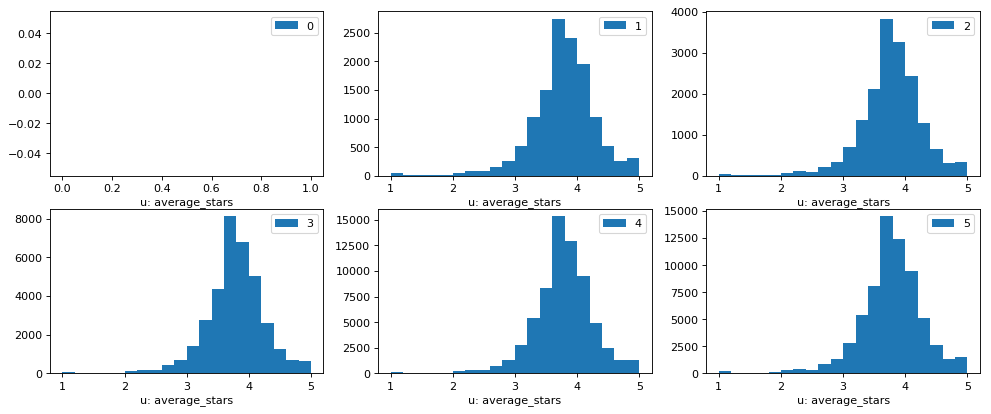

2


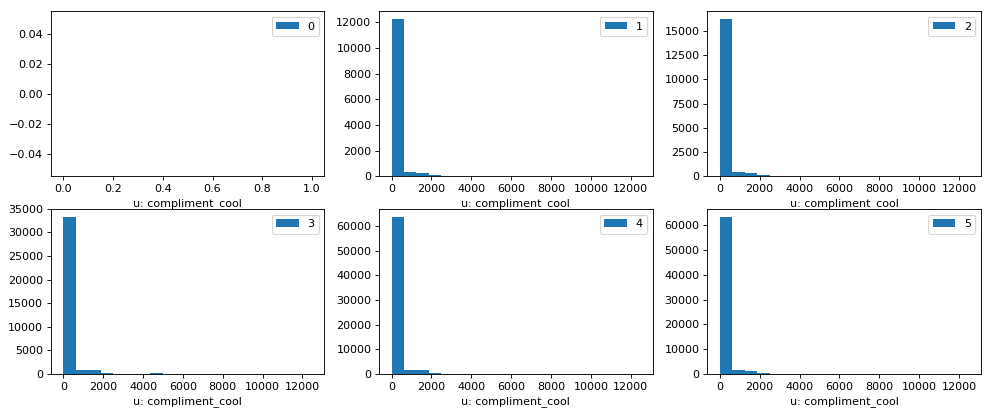

3


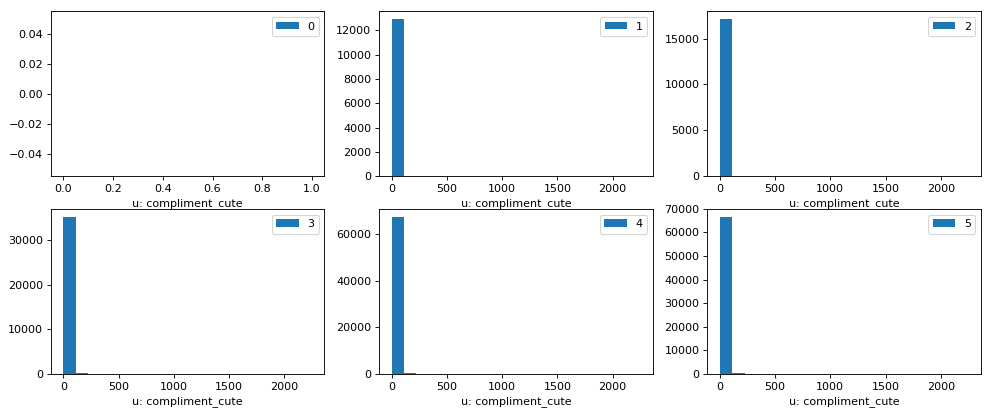

4


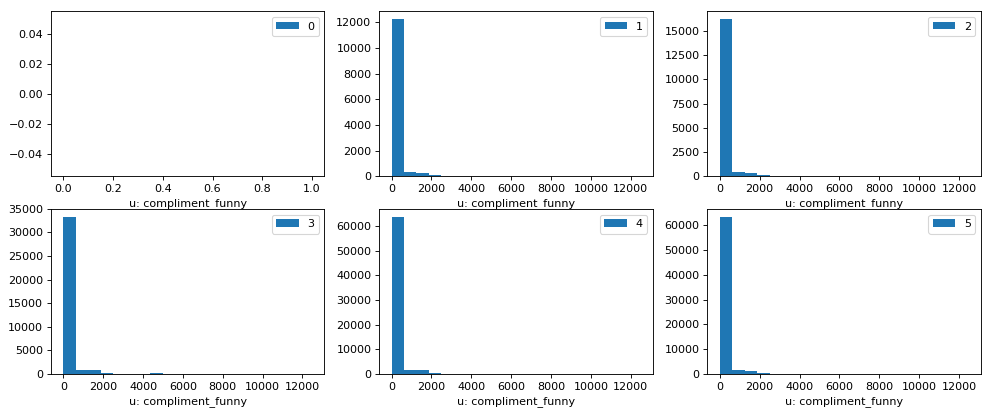

5


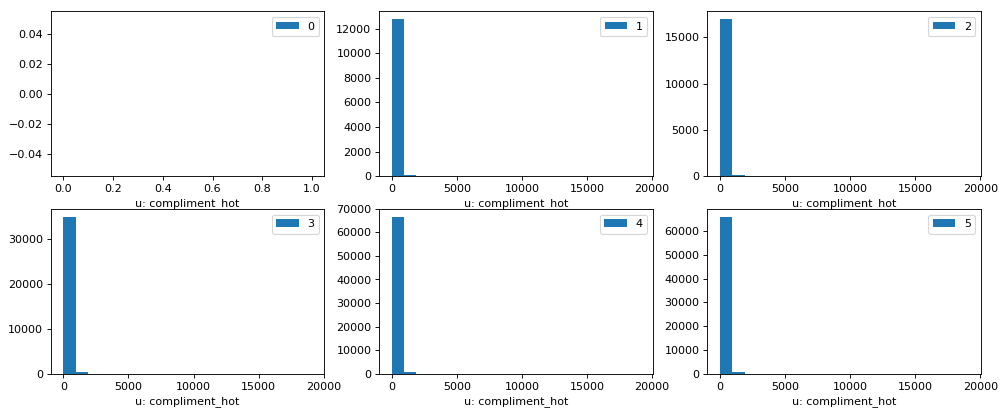

6


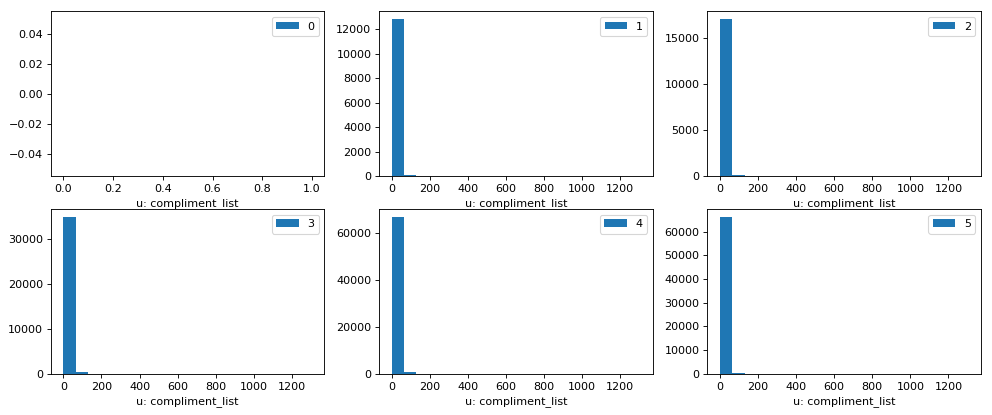

7


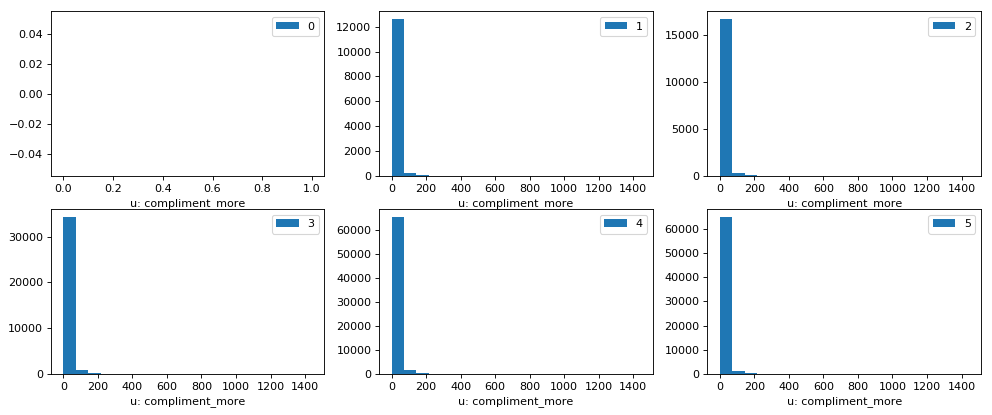

8


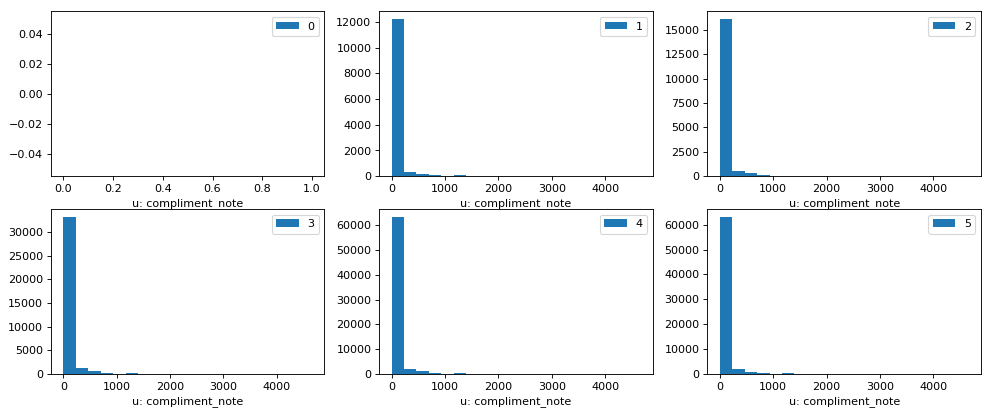

9


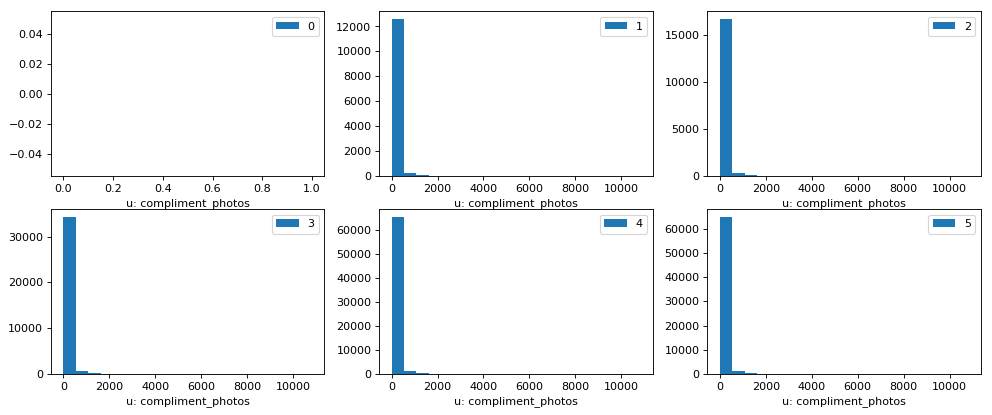

10


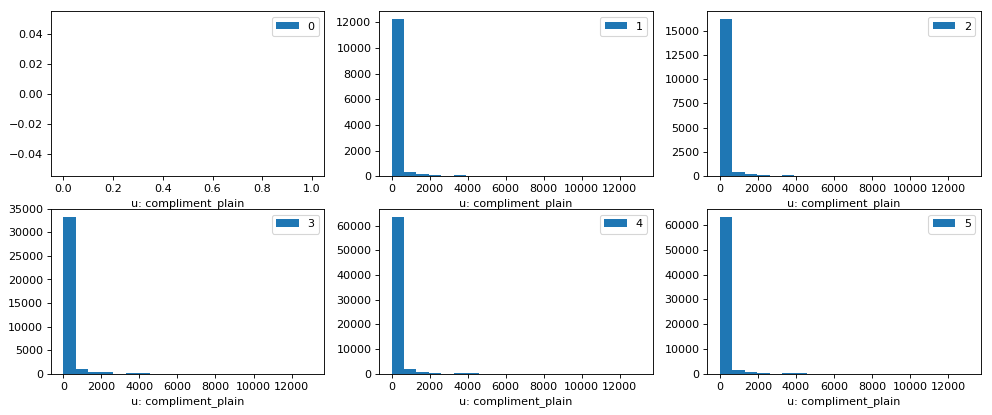

11


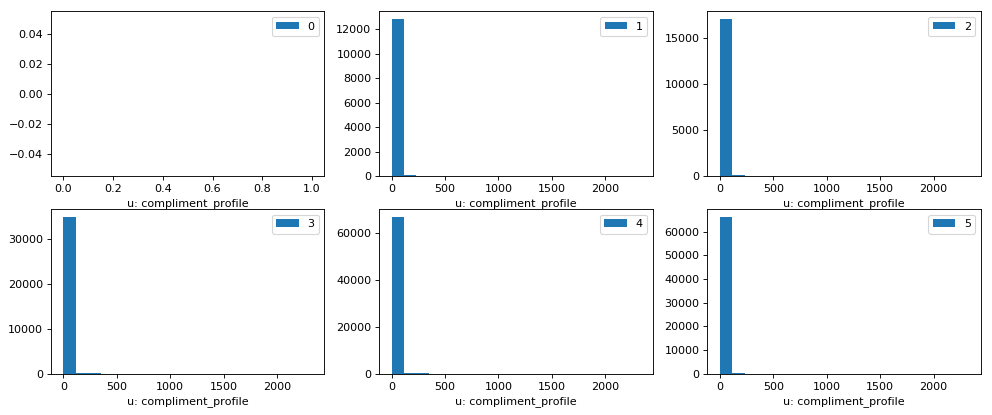

12


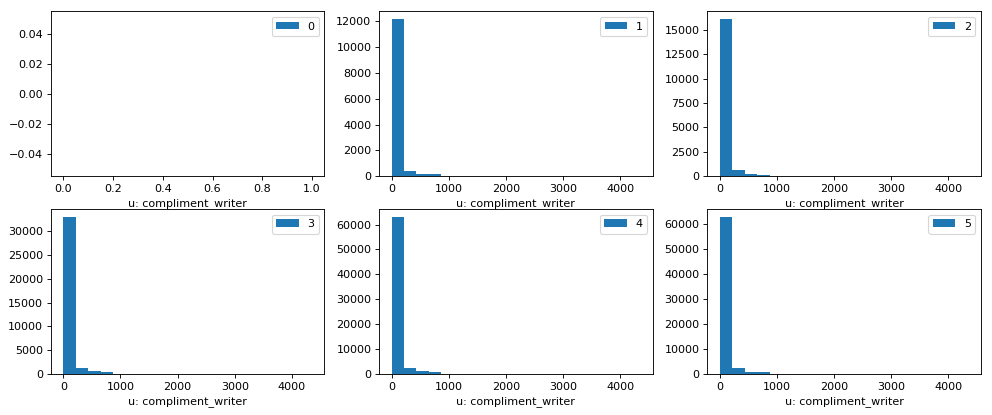

13


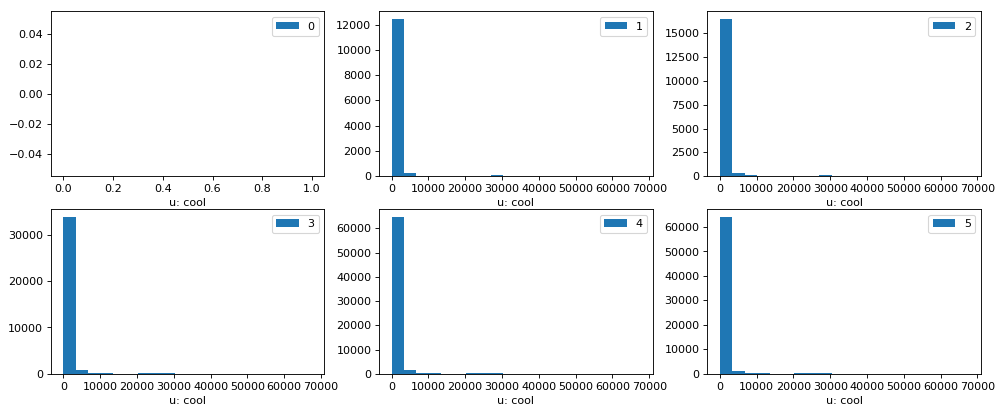

14


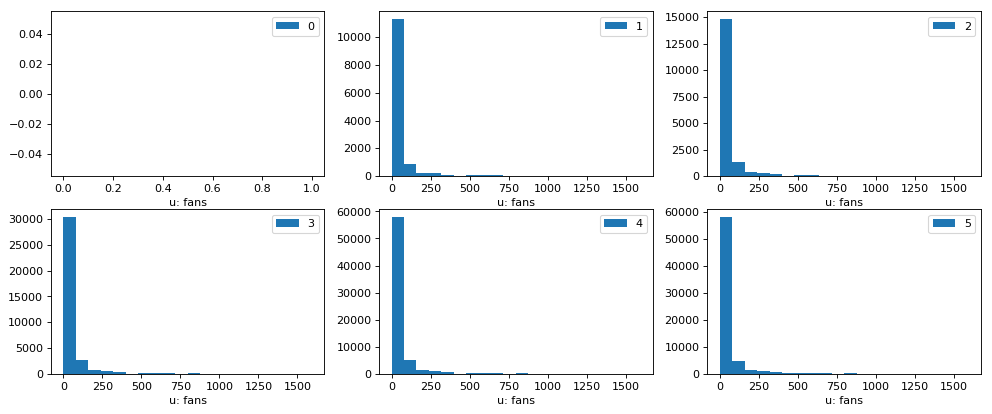

15


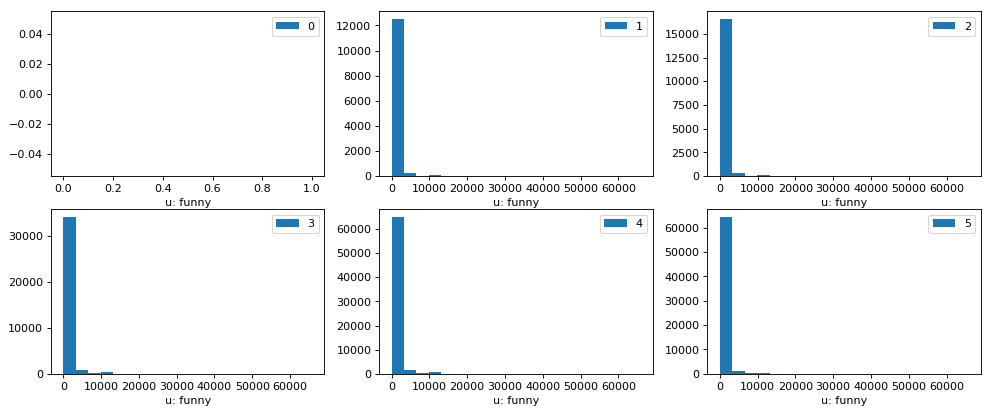

16


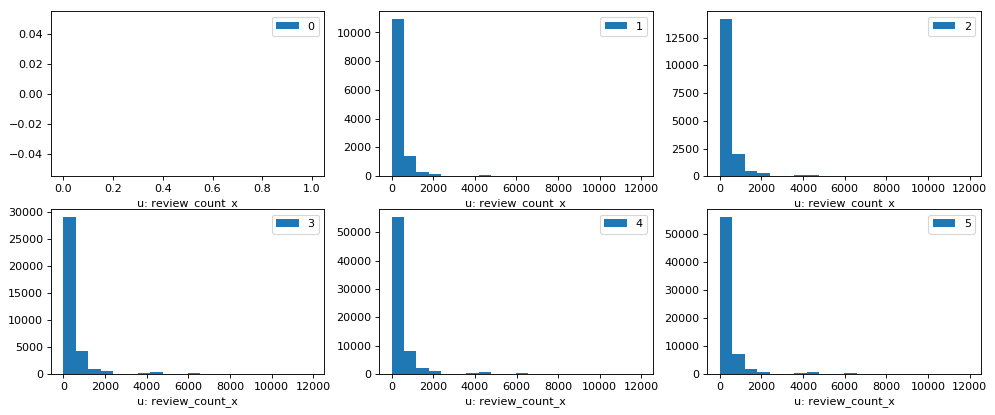

17


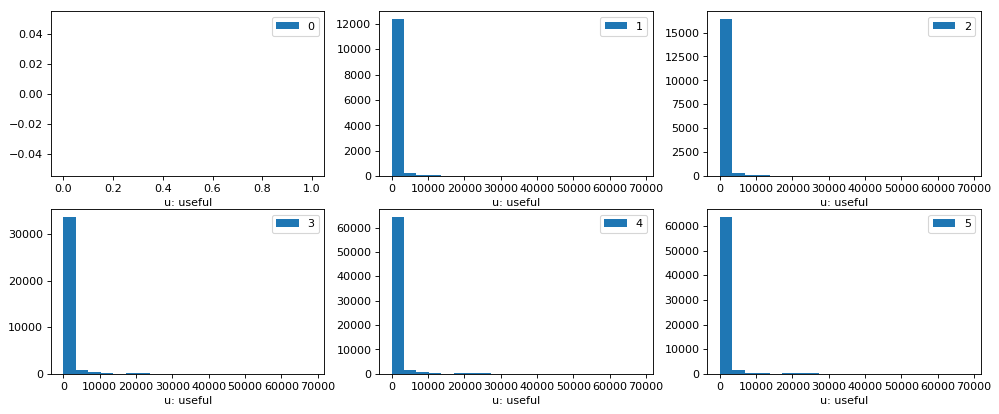

18


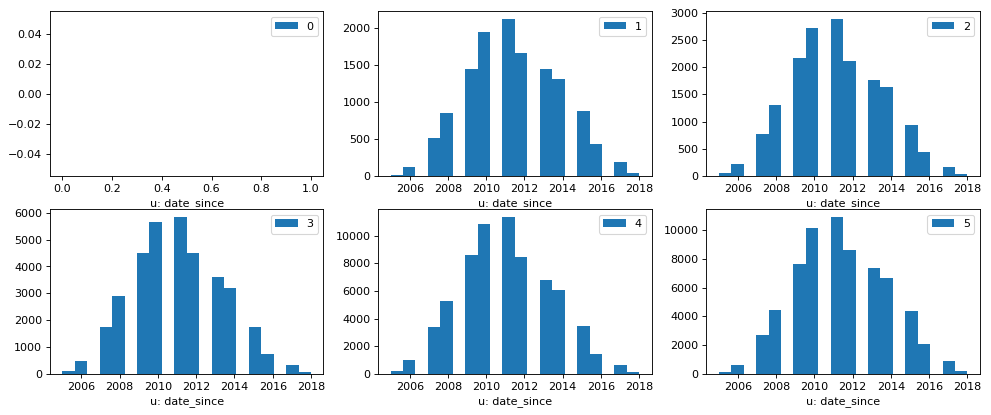

In [65]:
for i in range(1,len(user_cols)):
    print(i)
    plotClusteringRes(clusters, 'u', user_cols[i])